In [1]:
# Referenced from https://github.com/DL4mHealth/COMET/blob/main/data_preprocessing/PTB/PTB_preprocessing.ipynb
import os
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
from datautils import normalize, resample, R_Peaks, trial2sample, sample2trial

In [ ]:
# root path
path = "../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
root_path = os.path.join(path, "records500")
meta_path = os.path.join(path, "ptbxl_database.csv")
scp_path = os.path.join(path, "scp_statements.csv")
record_path = os.path.join(path, "RECORDS")

In [ ]:
label_dict = {
    "NORM": 0,
    "MI": 1,
    "STTC": 2,
    "CD": 3,
    "HYP": 4
}

In [ ]:
# get usable labels
meta = pd.read_csv(meta_path)
meta["scp_codes"] = meta.scp_codes.apply(lambda x: ast.literal_eval(x))
scp = pd.read_csv(scp_path, index_col=0)
scp = scp[scp.diagnostic == 1]

In [5]:
# scp_codes -> class
def aggregate_diagnostic(dic):
    tmp = []
    for key in dic.keys():
        if key in scp.index and scp.loc[key].diagnostic_class in label_dict:
            tmp.append(scp.loc[key].diagnostic_class)
    return list(set(tmp))

In [ ]:
meta["diagnostic"] = meta.scp_codes.apply(aggregate_diagnostic)
filtered = meta[meta["diagnostic"].apply(lambda x: len(x) == 1)]
filtered["diagnostic"] = filtered["diagnostic"].apply(lambda x: x[0]).replace(label_dict)
meta = filtered[["ecg_id", "patient_id", "diagnostic"]]
meta.sort_values(["patient_id", "ecg_id"], inplace=True)

/var/folders/s2/gg0gc5y53z979n2bskjqp6kc0000gn/T/ipykernel_40325/2861353121.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered['diagnostic'] = filtered['diagnostic'].apply(lambda x: x[0]).replace(label_dict)
/var/folders/s2/gg0gc5y53z979n2bskjqp6kc0000gn/T/ipykernel_40325/2861353121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['diagnostic'] = filtered['diagnostic'].apply(lambda x: x[0]).replace(label_dict)
/var/folders/s2/gg0gc5y53z979n2bskjqp6kc0000gn/T/ipykernel_40325/2861353121.py:5: Settin

In [ ]:
# int ecg_id -> str path name
dirs = np.arange(0, 22000, 1000)
def name2path(id):
    dir = f"{dirs[id // 1000]:05d}"
    return os.path.join(dir, f"{id:05d}_hr")
meta["ecg_id"] = meta["ecg_id"].apply(name2path)

/var/folders/s2/gg0gc5y53z979n2bskjqp6kc0000gn/T/ipykernel_40325/3690571210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['ecg_id'] = meta['ecg_id'].apply(name2path)


In [ ]:
# group signals by order of patient
group = meta.groupby("patient_id")["ecg_id"].apply(list)

In [ ]:
# get median R-Peak intervals for all trials, drop trials that contains nan or all zero
med_intervals = []
abnormal_trial = []
nan_trial = []
allzero_trial = []
for pid, tris in group.items():
    for tri in tris:
        tri_path = os.path.join(root_path, tri)
        ecg_data = wfdb.rdsamp(record_name=tri_path)[0]
        if np.all(ecg_data == 0):
            allzero_trial.append(tri_path)
            print(f"All zero: {tri_path}")
            continue
        if np.any(np.isnan(ecg_data)):
            nan_trial.append(tri_path)
            print(f"Nan: {tri_path}")
            continue
        trial = []
        for ch in range(ecg_data.shape[1]):
            data = resample(ecg_data[:,ch], freq1=500, freq2=250, kind="linear")
            trial.append(data)
        trial = np.array(trial).T
        trial_norm = normalize(trial)
        try:
            _, med, _ = R_Peaks(trial_norm)
            med_intervals.append(med.to_list())
        except IndexError:
            print(f"The trial is invalid with trial path {tri_path}")
            abnormal_trial.append(tri_path)
            pass
            
print(len(abnormal_trial), len(nan_trial), len(allzero_trial))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

0 0 0


,0,1,2,3,4,5,6,7,8,9,...,16234,16235,16236,16237,16238,16239,16240,16241,16242,16243
0,297.5,226.5,198.0,212.0,127.0,206.0,214.0,205.0,94.0,262.5,...,188.5,264.5,194.0,230.0,158.5,236.0,253.0,248.0,215.5,233.0
1,303.0,226.0,198.0,212.0,126.0,205.0,214.0,205.0,94.0,262.0,...,186.0,264.0,194.0,230.0,158.5,236.0,254.0,249.0,298.0,233.0
2,303.0,226.5,200.5,211.0,126.0,210.0,220.0,205.0,94.0,257.0,...,187.0,263.0,194.0,230.0,155.0,236.0,424.0,247.0,302.0,232.0
3,303.5,228.0,198.0,212.0,127.0,205.0,219.0,206.0,115.0,266.5,...,743.0,264.0,195.5,230.0,140.0,237.0,252.0,248.0,298.0,233.0
4,298.0,226.5,198.0,211.0,126.5,206.0,214.0,205.0,94.0,260.0,...,186.0,264.0,194.0,230.0,158.0,235.5,255.0,248.5,225.0,233.0
5,194.0,227.0,199.0,212.0,126.0,204.0,230.0,205.0,94.0,186.5,...,186.0,265.0,194.0,230.0,158.0,236.0,254.5,249.0,299.0,233.0
6,303.0,226.5,199.0,212.0,127.0,205.0,213.5,205.0,94.0,262.5,...,186.0,264.5,194.0,230.0,153.0,236.0,254.0,248.0,298.0,233.0
7,302.0,226.5,198.0,212.0,126.5,204.0,214.0,204.0,94.0,262.5,...,186.0,264.5,194.0,230.0,158.5,236.0,254.0,248.5,298.0,233.0
8,303.0,226.5,198.0,211.0,126.5,204.0,213.5,205.0,94.0,262.5,...,186.0,264.5,194.0,NaN,158.5,236.0,254.5,248.0,298.0,233.0
9,303.0,226.0,198.0,212.0,126.5,205.0,214.0,205.0,94.0,262.5,...,467.0,264.5,194.0,NaN,158.5,236.0,254.0,248.5,290.0,233.0


In [10]:
# 15820 records suitable for analysis
all_med = df_med_intervals.median()
print(all_med[all_med<=300].shape)
print(all_med[all_med<=300].max())
max_duration = 300

(15820,)
300.0


In [ ]:
# remove records that have median interval length greater than max duration
med_intervals = []
abnormal_trial = []
med_nan_trial = []
drop_trial = nan_trial + allzero_trial
for pid, tris in group.items():
    for tri in tris:
        tri_path = os.path.join(root_path, tri)
        if tri_path in drop_trial:
            continue
        ecg_data = wfdb.rdsamp(record_name=tri_path)[0]
        trial = []
        for ch in range(ecg_data.shape[1]):
            data = resample(ecg_data[:,ch], freq1=500, freq2=250, kind="linear")
            trial.append(data)
        trial = np.array(trial).T
        trial_norm = normalize(trial)
        try:
            _, med, _ = R_Peaks(trial_norm)
            if med.median() <= max_duration:
                if np.any(np.isnan(med)):
                    med_nan_trial.append(tri_path)
                    print(f"Med Nan: {tri_path}")
                    continue 
                med_intervals.append(med.to_list())
            else:
                print(f"The trial is an outlier with trial path {tri_path}")
                abnormal_trial.append(tri_path)
        except IndexError:
            print(f"The trial is invalid with trial path {tri_path}")
            abnormal_trial.append(tri_path)
            pass
            
print(len(abnormal_trial), len(med_nan_trial))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

The trial is an outlier with trial path ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/07000/07749_hr
The trial is an outlier with trial path ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/04000/04420_hr
Med Nan: ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/07000/07960_hr
Med Nan: ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/07000/07962_hr
The trial is an outlier with trial path ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/11000/11959_hr
The trial is an outlier with trial path ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/08000/08581_hr
Med Nan: ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/03000/03476_hr
The trial is an outlier with trial path ../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/01000/01232_

,0,1,2,3,4,5,6,7,8,9,...,15538,15539,15540,15541,15542,15543,15544,15545,15546,15547
0,226.5,198.0,212.0,127.0,206.0,214.0,205.0,94.0,262.5,231.0,...,202.0,188.5,264.5,194.0,158.5,236.0,253.0,248.0,215.5,233.0
1,226.0,198.0,212.0,126.0,205.0,214.0,205.0,94.0,262.0,231.0,...,202.0,186.0,264.0,194.0,158.5,236.0,254.0,249.0,298.0,233.0
2,226.5,200.5,211.0,126.0,210.0,220.0,205.0,94.0,257.0,232.0,...,202.0,187.0,263.0,194.0,155.0,236.0,424.0,247.0,302.0,232.0
3,228.0,198.0,212.0,127.0,205.0,219.0,206.0,115.0,266.5,232.0,...,203.0,743.0,264.0,195.5,140.0,237.0,252.0,248.0,298.0,233.0
4,226.5,198.0,211.0,126.5,206.0,214.0,205.0,94.0,260.0,232.0,...,202.0,186.0,264.0,194.0,158.0,235.5,255.0,248.5,225.0,233.0
5,227.0,199.0,212.0,126.0,204.0,230.0,205.0,94.0,186.5,153.5,...,202.0,186.0,265.0,194.0,158.0,236.0,254.5,249.0,299.0,233.0
6,226.5,199.0,212.0,127.0,205.0,213.5,205.0,94.0,262.5,231.0,...,202.0,186.0,264.5,194.0,153.0,236.0,254.0,248.0,298.0,233.0
7,226.5,198.0,212.0,126.5,204.0,214.0,204.0,94.0,262.5,231.0,...,202.0,186.0,264.5,194.0,158.5,236.0,254.0,248.5,298.0,233.0
8,226.5,198.0,211.0,126.5,204.0,213.5,205.0,94.0,262.5,231.0,...,202.0,186.0,264.5,194.0,158.5,236.0,254.5,248.0,298.0,233.0
9,226.0,198.0,212.0,126.5,205.0,214.0,205.0,94.0,262.5,231.0,...,202.0,467.0,264.5,194.0,158.5,236.0,254.0,248.5,290.0,233.0


In [ ]:
# main
feature_path = "../dataset/ptbxl/feature"
if not os.path.exists(feature_path):
    os.makedirs(feature_path)

dict_label = {}
sub_id = 1
drop_trial = drop_trial + abnormal_trial + med_nan_trial
for pid, tris in group.items():
    li_sub_segs = []
    for tri in tris:
        tri_path = os.path.join(root_path, tri)
        if tri_path in drop_trial:
            continue
        label = meta[meta["ecg_id"]==tri]["diagnostic"].values[0]
        dict_label[sub_id] = label
        ecg_data = wfdb.rdsamp(record_name=tri_path)[0] # data
        trial = []
        for ch in range(ecg_data.shape[1]):
            data = resample(ecg_data[:,ch], freq1=500, freq2=250, kind="linear")
            trial.append(data)
        trial = np.array(trial).T
        trial_norm = normalize(trial)
        samples = trial2sample(trial_norm, max_duration=300)
        segmentations = sample2trial(samples, size=6) # all segmentations of a trial
        for seg in segmentations:
            li_sub_segs.append(seg)
                    
    if li_sub_segs != list(): # Not None list
        array_sub = np.array(li_sub_segs)
        print(array_sub.shape)
        np.save(os.path.join(feature_path, f"feature_{sub_id:05d}"), array_sub)
        sub_id += 1
    else:
        print(f"The subject is None after preprocessing with the path {tri_path}")              

(1800, 12)
(1, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(4, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(5, 1800, 12)


(1800, 12)
(1, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(6, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(3, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(3, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(4, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(3, 1800, 12)


(1800, 12)
(1800, 12)
(2, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(5, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(4, 1800, 12)


(1800, 12)
(1, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(4, 1800, 12)


(1800, 12)
(1, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(1800, 12)
(4, 1800, 12)


(1800, 12)
(1800, 12)
(1800, 12)
(3, 1800, 12)


(1800, 12)
(1800, 12)
(2, 1800, 12)


(1800, 12)
(1800, 12)
(2, 1800, 12)


(1800, 12)
(1800, 12)
(2, 1800, 12)


(1800, 12)
(1, 1800,

In [15]:
len(dict_label)

14090

In [ ]:
# label.npy
label_path = "../dataset/ptbxl/label"
if not os.path.exists(label_path):
    os.makedirs(label_path)

df_label = pd.DataFrame([dict_label]).T
df_label = df_label.reset_index().astype("int64")
labels = df_label[[0, "index"]].values
np.save(os.path.join(label_path, "label"), labels)

In [ ]:
# test
sig = np.load("../dataset/ptbxl/feature/feature_01000.npy")
sig

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(1, 1800, 12))

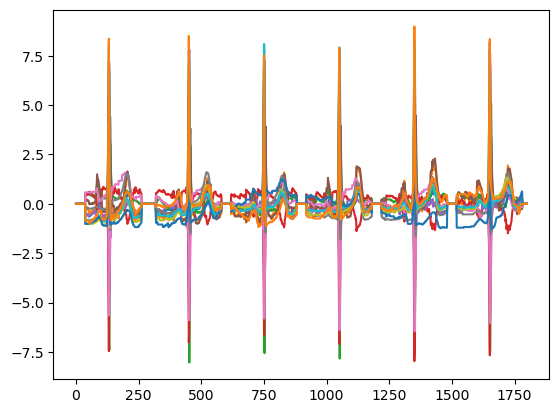

In [27]:
plt.plot(sig[0])

In [ ]:
labs = np.load("../dataset/ptbxl/label/label.npy")

In [3]:
unique_elements, counts = np.unique(labs[:, 0], return_counts=True)
element_counts = dict(zip(unique_elements, counts))
print(element_counts)

{np.int64(0): np.int64(8096), np.int64(1): np.int64(2089), np.int64(2): np.int64(2070), np.int64(3): np.int64(1355), np.int64(4): np.int64(480)}
